# Assignment 5 - Research Design

By Charlie Smith, University of South Alabama, Fall 2023, BUS 798

In [1]:
# Importing pandas for numerical variable analysis and os, numpy, string, and nltk for text variable analysis.

import pandas as pd
import os as os
import numpy as np
import string as string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\MCOB PHD
[nltk_data]     14\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Setting the directory where the text files of the Beige Books are stored
directory_path = "C:/Users/MCOB PHD 14/Dropbox/Charlie's Dissertation/Beige Books"

# Creating an empty list where the loop in the next step will save the Beige Book text files one by one
text_data = []

In [3]:
# Loop through the files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
        with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
            text_data.append(file.read())

Now we need to calculate a sentiment score for each Beige Book.

In [4]:
# Import the nltk vader package for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [5]:
# Earlier I read in the Beige Books texts as a list
    # Now doing it as a dataframe
    # Also including the filename so we can know which region, month, and year it's from

# Setting the directory where the text files of the Beige Books are stored
directory_path = "C:/Users/MCOB PHD 14/Dropbox/Charlie's Dissertation/Beige Books"

# Create empty lists to store text and file names
textDF = []
file_names = []

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
        with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
            # Append the text to the text_data list
            textDF.append(file.read())
            # Append the file name to the file_names list
            file_names.append(filename)

# Create a DataFrame from the text and file_names lists
data = {'text': textDF, 'file_name': file_names}
BeigeBookDF = pd.DataFrame(data)

In [6]:
# Create the function and run it on the Beige Book dataframe
def analyze_sentiment(BeigeBookDF):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(BeigeBookDF)
    
    compound_score = sentiment_scores['compound']
    
    if compound_score >= 0.05:
        sentiment = 'positive'
    elif compound_score <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return compound_score, sentiment

BeigeBookDF['compound_score'], BeigeBookDF['sentiment'] = zip(*BeigeBookDF['text'].apply(analyze_sentiment))


The sentiment score seems to be extreme: Either really low or really high (the possible range is -1 to 1).

There are many methods and tools for calculating sentiment. Vader may not be best for business documents because it's intended for less formal communication like social media.

So certainly I will need to explore other sentiment classifiers. But this will do for now to at least give us a score to work with.

### 1.3 DV - Macroeconomic index score

A monthly macroeconomic index for each Fed district was calculated based on the Philadelphia Fed's coincident index. Then the U.S. index was subtracted from this value to remove, at least partially, the national trends from the regional ones. These values represent the difference between each district and the national level.

A negative value indicates economic conditions were worse than the nation as a whole, while a positive value indicates district economic conditions were better than the national level.

In [7]:
# Reading in the data
districtDiffs = pd.read_csv('district_diffs.csv', encoding='latin1')
districtDiffs.head()

,Date,USPHCI,District 1,District 2,District 3,District 4,District 5,District 6,District 7,District 8,District 9,District 10,District 11,District 12
0,4/1/1979,46.14,0.22,9.92,11.87,16.25,-0.15,-2.42,15.90,11.08,4.86,3.98,-5.66,-5.63
1,5/1/1979,46.37,0.22,9.82,11.79,16.14,-0.24,-2.51,15.80,10.93,4.79,3.90,-5.73,-5.70
2,6/1/1979,46.50,0.30,9.79,11.79,16.09,-0.27,-2.53,15.70,10.83,4.76,3.86,-5.71,-5.65
3,7/1/1979,46.62,0.28,9.66,11.69,15.90,-0.29,-2.62,15.49,10.62,4.65,3.81,-5.67,-5.62
4,8/1/1979,46.68,0.43,9.67,11.62,15.83,-0.32,-2.54,15.23,10.52,4.59,3.83,-5.57,-5.60


In [8]:
# Want to calculate overall mean for the combined districts
# Select the columns you want to include in the mean calculation
district_columns = ['District 1', 'District 2', 'District 3', 'District 4', 'District 5', 'District 6', 'District 7', 'District 8', 'District 9', 'District 10', 'District 11', 'District 12']

# Calculate the overall summary statistics
dv_mean = districtDiffs[district_columns].mean().mean()
dv_median = districtDiffs[district_columns].median().median()
    # Mode omitted because it's not really meaningful to calculate the mode of a continuous variable like this.


# Print the overall mean
print("DV Mean:", dv_mean)
print("DV Median:", dv_median)


DV Mean: 2.0042464040025005
DV Median: 0.985


## Part 2 - Descriptive Statistics on Units of Analysis

### 2.1 - Merging datasets

In [9]:
# Changing the Date variable to read as a datetime
districtDiffs['Date'] = pd.to_datetime(districtDiffs['Date'])

In [10]:
# Reshape districtDiffs dataframe from wide to long
districtLong = pd.melt(districtDiffs, id_vars=["Date", "USPHCI"], var_name="District", value_name="Value")

# Extract the numeric part from the "District" names and convert to integers
districtLong["District"] = districtLong["District"].str.extract(r'(\d+)').astype(int)

# Sort the DataFrame by "Date" and "District" columns
districtLong = districtLong.sort_values(by=["Date", "District"])

# Reset the index
districtLong.reset_index(drop=True, inplace=True)

# Display the long-format DataFrame
# print(districtLong)


In [12]:
# Define a mapping of city abbreviations to district numbers
city_to_district = {
    "bo": 1,
    "ny": 2,
    "ph": 3,
    "cl": 4,
    "ri": 5,
    "at": 6,
    "ch": 7,
    "sl": 8,
    "mn": 9,
    "kc": 10,
    "da": 11,
    "sf": 12,
}

# Define a mapping of month codes (as named in the original text files of the Beige Books) to month names
month_to_name = {
    "1": "December",
    "2": "October",
    "3": "September",
    "4": "July",
    "5": "June",
    "6": "May",
    "7": "March",
    "8": "January",
}

# Define a mapping of month names to month numbers
name_to_month_numerical = {
    "December": "12",
    "October": "10",
    "September": "09",
    "July": "07",
    "June": "06",
    "May": "05",
    "March": "03",
    "January": "01",
}


In [13]:
# Create a new dataframe that is a copy of BeigeBookDF
bbDF = BeigeBookDF

# Extract the year, city, and month code into separate columns
bbDF[['Year', 'City', 'MonthCode']] = BeigeBookDF['file_name'].str.extract(r'(\d{4})_(\w{2}) \((\d)\).txt')

# Map the city abbreviations to district numbers
bbDF['District'] = bbDF['City'].map(city_to_district)

# Map the month code to month names
bbDF['MonthName'] = bbDF['MonthCode'].map(month_to_name)

# Map the month names to numerical month numbers
bbDF['MonthNumerical'] = bbDF['MonthName'].map(name_to_month_numerical)

# Create a new column with the formatted date
bbDF['Date'] = bbDF['Year'] + '-' + BeigeBookDF['MonthNumerical'] + '-01'

In [14]:
# Convert the 'Date' column to a datetime data type
bbDF['Date'] = pd.to_datetime(bbDF['Date'])

In [20]:
# Use the merge function to join the DataFrames based on the 'Date' and 'District' columns
bbMerged = districtLong.merge(bbDF, on=['Date', 'District'])

# Print the resulting DataFrame
# print(bbMerged)


In [24]:
# Going to rename the Value column and drop the 'FormattedDate' column
bbMerged = bbMerged.rename(columns={'Value': 'econ_index'})
bbMerged.head()
# bbMerged = bbMerged.rename(columns={'Value': 'econ_index'})

,Date,USPHCI,District,econ_index,text,file_name,compound_score,sentiment,Year,City,MonthCode,MonthName,MonthNumerical
0,1979-05-01,46.37,1,0.22,"May 16, 1979\nBusiness activity in the First ...",1979_bo (6).txt,0.8284,positive,1979,bo,6,May,05
1,1979-05-01,46.37,2,9.82,"May 16, 1979 \nSecond District business activ...",1979_ny (6).txt,0.9868,positive,1979,ny,6,May,05
2,1979-05-01,46.37,3,11.79,"May 16, 1979 \nThird District economic activi...",1979_ph (6).txt,0.9954,positive,1979,ph,6,May,05
3,1979-05-01,46.37,4,16.14,"May 16, 1979 \nManufacturing activity in the ...",1979_cl (6).txt,0.3092,positive,1979,cl,6,May,05
4,1979-05-01,46.37,5,-0.24,"May 16, 1979 \nMost indications are that Fift...",1979_ri (6).txt,0.9954,positive,1979,ri,6,May,05


## Part 3 - Data Visualization

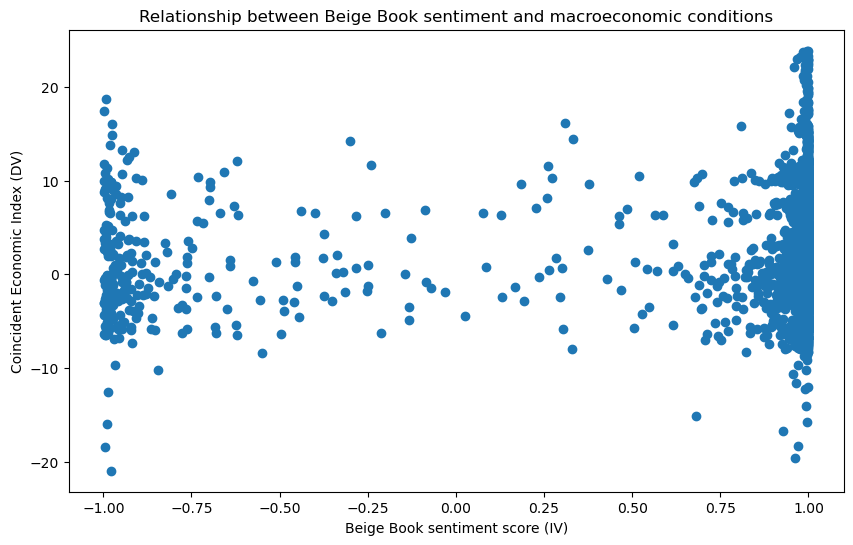

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(bbMerged['compound_score'], bbMerged['econ_index'])
plt.title('Relationship between Beige Book sentiment and macroeconomic conditions')
plt.xlabel('Beige Book sentiment score (IV)')
plt.ylabel('Coincident Economic Index (DV)')
plt.show()

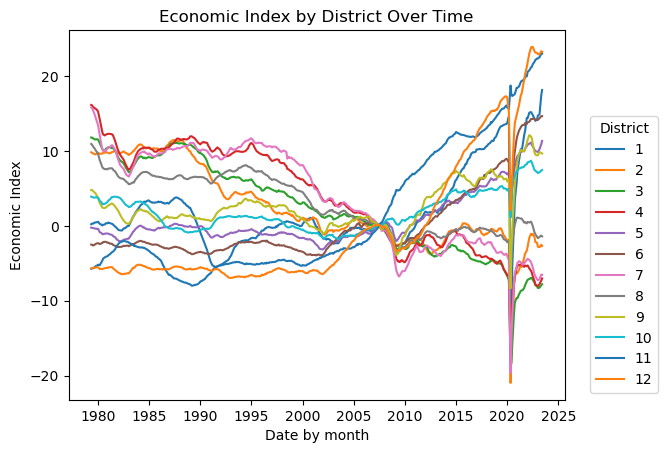

In [27]:
# Group the data by 'District'
grouped = bbMerged.groupby('District')

# Create a line plot for each group
for name, group in grouped:
    plt.plot(group['Date'], group['econ_index'], label=name)

# Add labels and a legend
plt.xlabel('Date by month')
plt.ylabel('Economic Index')
plt.title('Economic Index by District Over Time')
#plt.xticks(range(1, 45 + 1, 5), rotation=45)
plt.legend(title='District', loc='lower center', bbox_to_anchor=(1.12, 0), ncol=1)
# Show the plot
plt.show()


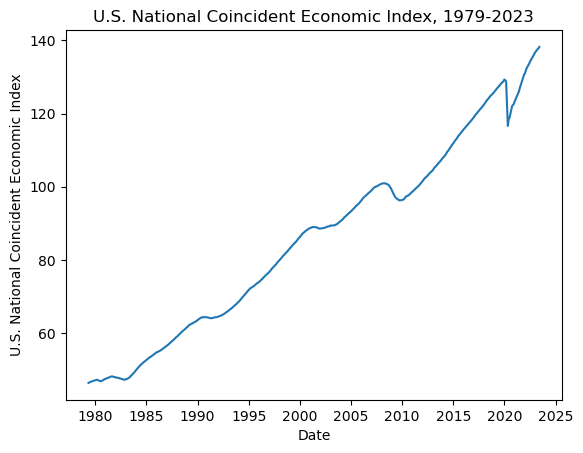

In [28]:
# Plotting the national level of the index over time
plt.plot(bbMerged['Date'], bbMerged['USPHCI'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('U.S. National Coincident Economic Index')
plt.title('U.S. National Coincident Economic Index, 1979-2023')

# Show the plot
plt.show()


# Research Design

In [44]:
import os
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize


In [45]:
sia = SentimentIntensityAnalyzer()

def calculate_sentiment_scores(text):
    sentences = sent_tokenize(text)
    scores = []

    for sentence in sentences:
        sentiment_score = sia.polarity_scores(sentence)
        scores.append(sentiment_score)

    return scores


In [47]:
results = []

In [48]:
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):  # Assuming your text files have a .txt extension
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r') as file:
            text = file.read()
        
        sentiment_scores = calculate_sentiment_scores(text)
        results.append({
            'File': filename,
            'Sentiment Scores': sentiment_scores
        })


In [49]:
sentiment_scores = []
for sentence in sentences:
    sentiment = sia.polarity_scores(sentence)
    sentiment_scores.append(sentiment)

NameError: name 'sentences' is not defined

In [50]:
df = pd.DataFrame({'Sentence': sentences, 'Sentiment Scores': sentiment_scores})

NameError: name 'sentences' is not defined

In [37]:
print(df.head())
print(df.describe())

                                            Sentence  \
0  December 9, 1970\nThe economy of the Southeast...   
1  Although layoffs \ncontinue to dominate the em...   
2  Construction of low-income housing and road bu...   
3  A soon-to-be-released survey indicates \nTenne...   
4  On the \nother hand, numerous announcements of...   

                                    Sentiment Scores  
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
1  {'neg': 0.057, 'neu': 0.833, 'pos': 0.11, 'com...  
2  {'neg': 0.0, 'neu': 0.773, 'pos': 0.227, 'comp...  
3  {'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'comp...  
4  {'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp...  
                                                 Sentence  \
count                                                  45   
unique                                                 45   
top     December 9, 1970\nThe economy of the Southeast...   
freq                                                    1   

                           

In [38]:
# Need to break out the four types of sentiment scores into separate columns
df['Negative_Score'] = [sentiment['neg'] for sentiment in df['Sentiment Scores']]
df['Neutral_Score'] = [sentiment['neu'] for sentiment in df['Sentiment Scores']]
df['Positive_Score'] = [sentiment['pos'] for sentiment in df['Sentiment Scores']]
df['Compound_Score'] = [sentiment['compound'] for sentiment in df['Sentiment Scores']]

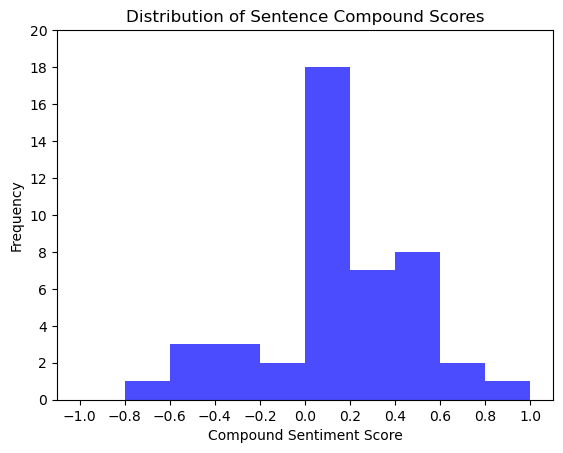

In [40]:
num_bins = 10
bin_width = (1 - (-1)) / num_bins
bin_edges = np.linspace(-1, 1, num_bins + 1)

plt.hist(df['Compound_Score'], bins=bin_edges, range = (-1, 1), color='blue', alpha=0.7)
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Compound Scores')
plt.xticks(bin_edges)
y_ticks = list(range(0,22, 2))
plt.yticks(y_ticks)
plt.show()

In [41]:
# Going to do the above for every document
    # Going to start with the bbMerged file, which already has Beige Book documents listed by city and date
    # Going to create a new df that drops some of the extra stuff leftover in bbMerged

bbSimple = bbMerged
bbSimple.drop('sentiment', axis=1, inplace=True)
bbSimple.drop('file_name', axis=1, inplace=True)
bbSimple.drop('compound_score', axis=1, inplace=True)
bbSimple.drop('MonthCode', axis=1, inplace=True)

In [118]:
# Going to do the above for every document
    # Going to start with the bbMerged file, which already has Beige Book documents listed by city and date
    # Going to create a new df that drops some of the extra stuff leftover in bbMerged

bbLevels = bbMergedLevels
bbLevels.drop('sentiment', axis=1, inplace=True)
bbLevels.drop('file_name', axis=1, inplace=True)
bbLevels.drop('MonthCode', axis=1, inplace=True)

In [119]:
# Now calculating the compound score for each sentence in each Beige Book
    # Then saving that as a list within the bbSimple dataframe

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate the compound sentiment score
def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    compound_scores = [sid.polarity_scores(sentence)['compound'] for sentence in sentences]
    return compound_scores

# Assuming 'bbSimple' is your DataFrame
bbLevels['compound_sentiment'] = bbLevels['text'].apply(calculate_sentiment)


In [120]:
# bbSimple.head()
bbLevels.head()

,Date,USPHCI,District,econ_index,text,compound_score,Year,City,MonthName,MonthNumerical,compound_sentiment
0,1979-05-01,46.37,1,46.59,"May 16, 1979\nBusiness activity in the First ...",0.8284,1979,bo,May,05,"[0.5563, 0.2732, 0.4019, -0.6705, 0.0, 0.7501,..."
1,1979-05-01,46.37,2,56.19,"May 16, 1979 \nSecond District business activ...",0.9868,1979,ny,May,05,"[0.3182, 0.1531, 0.5994, 0.0772, -0.128, 0.0, ..."
2,1979-05-01,46.37,3,58.16,"May 16, 1979 \nThird District economic activi...",0.9954,1979,ph,May,05,"[0.0, 0.0, 0.4754, 0.0, 0.0, -0.4215, 0.4019, ..."
3,1979-05-01,46.37,4,62.51,"May 16, 1979 \nManufacturing activity in the ...",0.3092,1979,cl,May,05,"[0.3818, -0.2144, 0.0, 0.4767, 0.0, 0.0, 0.0, ..."
4,1979-05-01,46.37,5,46.13,"May 16, 1979 \nMost indications are that Fift...",0.9954,1979,ri,May,05,"[0.3182, 0.0, 0.4215, -0.5719, -0.0258, -0.611..."


In [122]:
# Example: Calculate the mean and median sentiment scores for each document
# bbSimple['mean_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
# bbSimple['median_sentiment'] = bbSimple['compound_sentiment'].apply(lambda x: sorted(x)[len(x) // 2] if len(x) > 0 else 0)

bbLevels['mean_sentiment'] = bbLevels['compound_sentiment'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
bbLevels['median_sentiment'] = bbLevels['compound_sentiment'].apply(lambda x: sorted(x)[len(x) // 2] if len(x) > 0 else 0)

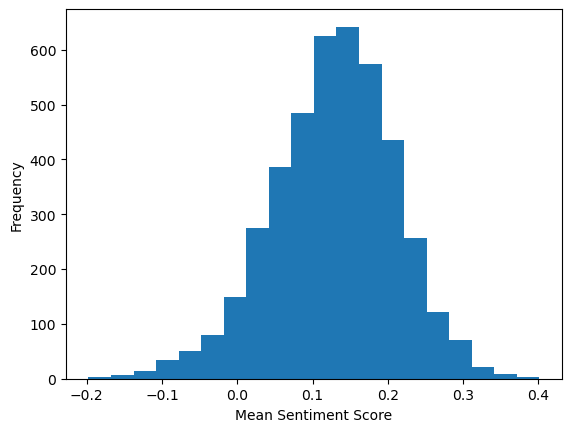

In [123]:
# Example: Create a histogram of compound sentiment scores
plt.hist(bbLevels['mean_sentiment'], bins=20)
plt.xlabel('Mean Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [124]:
# Example: Identify documents with mostly positive sentiment
positive_documents = bbLevels[bbLevels['mean_sentiment'] > 0.2]


In [125]:
positive_documents.describe()

,USPHCI,District,econ_index,compound_score,mean_sentiment,median_sentiment
count,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,88.713182,6.344156,91.404481,0.998184,0.240467,0.273888
std,24.295318,3.333207,24.368318,0.001966,0.034376,0.078284
min,46.370000,1.000000,40.670000,0.975600,0.200027,0.000000
25%,67.800000,3.000000,73.352500,0.997900,0.214274,0.250000
50%,91.050000,6.000000,91.925000,0.998800,0.230850,0.273200
75%,108.982500,9.000000,109.330000,0.999200,0.258162,0.318200
max,138.240000,12.000000,149.050000,0.999900,0.401186,0.526700


In [49]:
# Calculate deciles

import numpy as np

# Define a list of desired deciles (10th, 20th, ..., 90th percentiles)
deciles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Calculate the specified deciles for each document
for decile in deciles:
    column_name = f'{decile}th_decile_sentiment'
    bbSimple[column_name] = bbSimple['compound_sentiment'].apply(lambda x: np.percentile(x, decile) if len(x) > 0 else 0)


In [126]:
# Calculate deciles for levels version

import numpy as np

# Define a list of desired deciles (10th, 20th, ..., 90th percentiles)
deciles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Calculate the specified deciles for each document
for decile in deciles:
    column_name = f'{decile}th_decile_sentiment'
    bbLevels[column_name] = bbLevels['compound_sentiment'].apply(lambda x: np.percentile(x, decile) if len(x) > 0 else 0)

In [51]:
# Doing quartiles as well

import numpy as np

# Define a list of desired quartiles (25th, 50th, and 75th percentiles)
quartiles = [25, 50, 75]

# Calculate the specified quartiles for each document
for quartile in quartiles:
    column_name = f'{quartile}th_quartile_sentiment'
    bbSimple[column_name] = bbSimple['compound_sentiment'].apply(lambda x: np.percentile(x, quartile) if len(x) > 0 else 0)


In [127]:
# Doing quartiles for levels, too

import numpy as np

# Define a list of desired quartiles (25th, 50th, and 75th percentiles)
quartiles = [25, 50, 75]

# Calculate the specified quartiles for each document
for quartile in quartiles:
    column_name = f'{quartile}th_quartile_sentiment'
    bbLevels[column_name] = bbLevels['compound_sentiment'].apply(lambda x: np.percentile(x, quartile) if len(x) > 0 else 0)


In [129]:
# Calculating interquartile range
bbSimple['IQR_sentiment'] = bbSimple['75th_quartile_sentiment'] - bbSimple['25th_quartile_sentiment']

# Calculating interquartile range
bbLevels['IQR_sentiment'] = bbLevels['75th_quartile_sentiment'] - bbLevels['25th_quartile_sentiment']

In [130]:
bbLevels['IQR_sentiment'].describe()

count    4242.000000
mean        0.443621
std         0.107984
min         0.000000
25%         0.381800
50%         0.440400
75%         0.509800
max         0.994250
Name: IQR_sentiment, dtype: float64

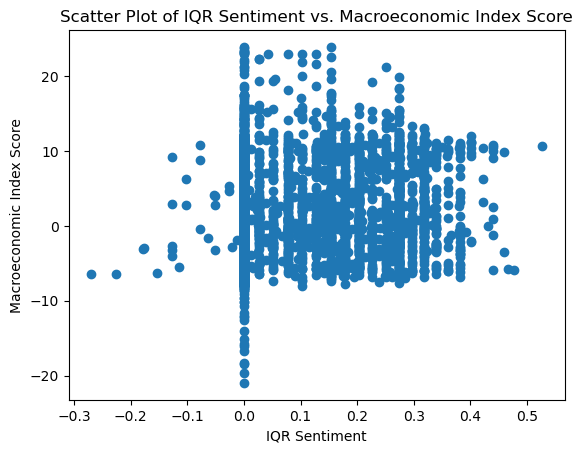

In [57]:
# bbSimple is your DataFrame
plt.scatter(bbSimple['median_sentiment'], bbSimple['econ_index'])
plt.xlabel('IQR Sentiment')
plt.ylabel('Macroeconomic Index Score')
plt.title('Scatter Plot of IQR Sentiment vs. Macroeconomic Index Score')
plt.show()


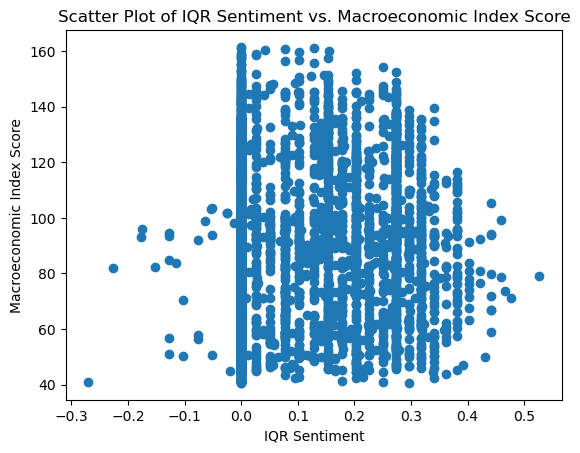

In [131]:
# bbLevels is your DataFrame
plt.scatter(bbLevels['median_sentiment'], bbLevels['econ_index'])
plt.xlabel('IQR Sentiment')
plt.ylabel('Macroeconomic Index Score')
plt.title('Scatter Plot of IQR Sentiment vs. Macroeconomic Index Score')
plt.show()


In [58]:
# Get my original compound sentiment score for the overall Beige Book back

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Calculate the compound sentiment score for each row and store it in a new column
bbSimple['compound_sentiment'] = bbSimple['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Display the updated DataFrame
bbSimple.head()

,Date,USPHCI,District,econ_index,text,Year,City,MonthName,MonthNumerical,compound_sentiment,...,40th_decile_sentiment,50th_decile_sentiment,60th_decile_sentiment,70th_decile_sentiment,80th_decile_sentiment,90th_decile_sentiment,25th_quartile_sentiment,50th_quartile_sentiment,75th_quartile_sentiment,IQR_sentiment
0,1979-05-01,46.37,1,0.22,"May 16, 1979\nBusiness activity in the First ...",1979,bo,May,05,0.8284,...,0.0000,0.0000,0.21472,0.38582,0.53680,0.64602,-0.0258,0.0000,0.40190,0.42770
1,1979-05-01,46.37,2,9.82,"May 16, 1979 \nSecond District business activ...",1979,ny,May,05,0.9868,...,0.0772,0.1761,0.27320,0.34000,0.42150,0.55420,0.0000,0.1761,0.37150,0.37150
2,1979-05-01,46.37,3,11.79,"May 16, 1979 \nThird District economic activi...",1979,ph,May,05,0.9954,...,0.0000,0.0000,0.11406,0.31820,0.39990,0.57485,0.0000,0.0000,0.37135,0.37135
3,1979-05-01,46.37,4,16.14,"May 16, 1979 \nManufacturing activity in the ...",1979,cl,May,05,0.3092,...,0.0000,0.0000,0.00000,0.10100,0.30932,0.39371,-0.2291,0.0000,0.20450,0.43360
4,1979-05-01,46.37,5,-0.24,"May 16, 1979 \nMost indications are that Fift...",1979,ri,May,05,0.9954,...,0.0000,0.0857,0.27320,0.45880,0.54230,0.70960,-0.0387,0.0857,0.50225,0.54095


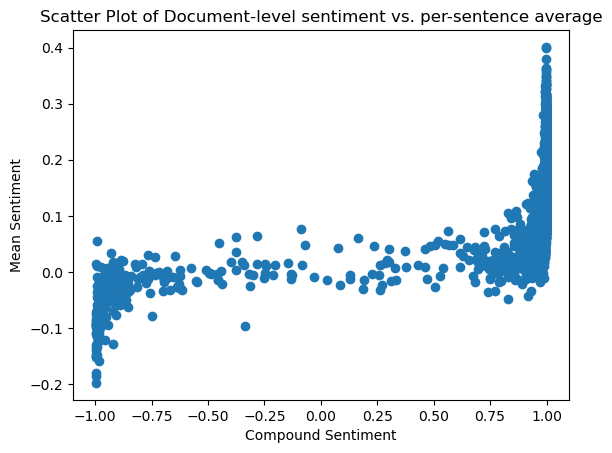

In [134]:
# Plot compound score calculated for the overall document versus the mean of the compound score for each sentence
plt.scatter(bbSimple['compound_sentiment'], bbSimple['mean_sentiment'])
plt.xlabel('Compound Sentiment')
plt.ylabel('Mean Sentiment')
plt.title('Scatter Plot of Document-level sentiment vs. per-sentence average')
plt.show()
# The relationship is there, but calculating the overall compound for the document tends to create extremes
    # Many in the overall are clustered around -1 and 1
    # The sentence-level captures more variation, perhaps, within the document while still showing the overall message

In [133]:
bbLevels.columns

Index(['Date', 'USPHCI', 'District', 'econ_index', 'text', 'compound_score',
       'Year', 'City', 'MonthName', 'MonthNumerical', 'compound_sentiment',
       'mean_sentiment', 'median_sentiment', '10th_decile_sentiment',
       '20th_decile_sentiment', '30th_decile_sentiment',
       '40th_decile_sentiment', '50th_decile_sentiment',
       '60th_decile_sentiment', '70th_decile_sentiment',
       '80th_decile_sentiment', '90th_decile_sentiment',
       '25th_quartile_sentiment', '50th_quartile_sentiment',
       '75th_quartile_sentiment', 'IQR_sentiment'],
      dtype='object')

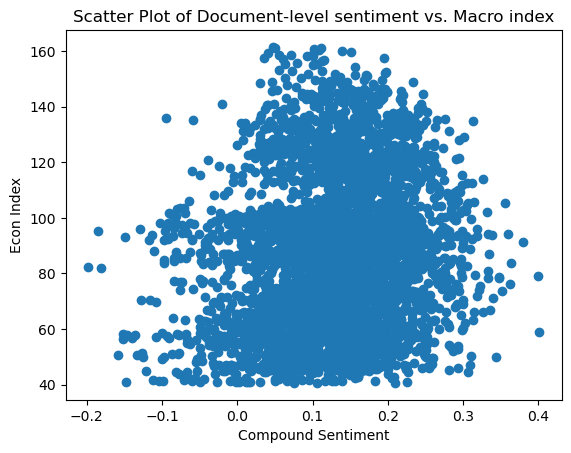

In [138]:
# Same thing but for levels now
# Plot compound score calculated for the overall document versus the mean of the compound score for each sentence
plt.scatter(bbLevels['mean_sentiment'], bbLevels['econ_index'])
plt.xlabel('Compound Sentiment')
plt.ylabel('Econ Index')
plt.title('Scatter Plot of Document-level sentiment vs. Macro index')
plt.show()
# The relationship is there, but calculating the overall compound for the document tends to create extremes
    # Many in the overall are clustered around -1 and 1
    # The sentence-level captures more variation, perhaps, within the document while still showing the overall message

In [62]:
from textblob import TextBlob

# Assuming bbSimple is your DataFrame
# Define a function to calculate sentiment polarity using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Create a new column 'Blob_sentiment' in your DataFrame with sentiment scores
bbSimple['Blob_sentiment'] = bbSimple['text'].apply(get_sentiment)

# Display the updated DataFrame
bbSimple.head()

,Date,USPHCI,District,econ_index,text,Year,City,MonthName,MonthNumerical,compound_sentiment,...,50th_decile_sentiment,60th_decile_sentiment,70th_decile_sentiment,80th_decile_sentiment,90th_decile_sentiment,25th_quartile_sentiment,50th_quartile_sentiment,75th_quartile_sentiment,IQR_sentiment,Blob_sentiment
0,1979-05-01,46.37,1,0.22,"May 16, 1979\nBusiness activity in the First ...",1979,bo,May,05,0.8284,...,0.0000,0.21472,0.38582,0.53680,0.64602,-0.0258,0.0000,0.40190,0.42770,0.173474
1,1979-05-01,46.37,2,9.82,"May 16, 1979 \nSecond District business activ...",1979,ny,May,05,0.9868,...,0.1761,0.27320,0.34000,0.42150,0.55420,0.0000,0.1761,0.37150,0.37150,0.109751
2,1979-05-01,46.37,3,11.79,"May 16, 1979 \nThird District economic activi...",1979,ph,May,05,0.9954,...,0.0000,0.11406,0.31820,0.39990,0.57485,0.0000,0.0000,0.37135,0.37135,0.070790
3,1979-05-01,46.37,4,16.14,"May 16, 1979 \nManufacturing activity in the ...",1979,cl,May,05,0.3092,...,0.0000,0.00000,0.10100,0.30932,0.39371,-0.2291,0.0000,0.20450,0.43360,0.035510
4,1979-05-01,46.37,5,-0.24,"May 16, 1979 \nMost indications are that Fift...",1979,ri,May,05,0.9954,...,0.0857,0.27320,0.45880,0.54230,0.70960,-0.0387,0.0857,0.50225,0.54095,0.104038


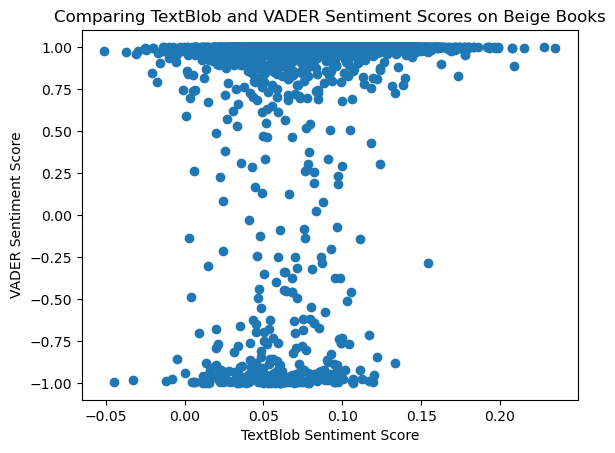

In [63]:
# Compare VADER and TextBlob sentiments
plt.scatter(bbSimple['Blob_sentiment'], bbSimple['compound_sentiment'])
plt.xlabel('TextBlob Sentiment Score')
plt.ylabel('VADER Sentiment Score')
plt.title('Comparing TextBlob and VADER Sentiment Scores on Beige Books')
plt.show()

In [64]:
from finvader import finvader

[nltk_data] Downloading package vader_lexicon to C:\Users\MCOB PHD
[nltk_data]     14\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [65]:
text_test = text_data[4400]
scores = finvader(text_test, use_sentibignomics = True, use_henry = True, indicator="compound")
print(scores)

-0.9883


In [66]:
# Calculate sentiment using finVADER and save it as a new column called financial_sentiment
def calculate_sentiment(text):
    sentiment = finvader(text, use_sentibignomics=True, use_henry=True, indicator="compound")
    return sentiment

# Create a new column 'financial_sentiment' to store the sentiment scores
bbSimple['financial_sentiment'] = bbSimple['text'].apply(calculate_sentiment)


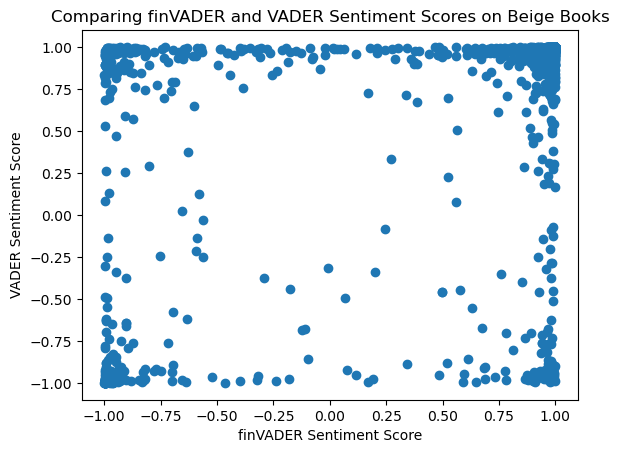

In [68]:
# Compare VADER and finVADER sentiments
plt.scatter(bbSimple['financial_sentiment'], bbSimple['compound_sentiment'])
plt.xlabel('finVADER Sentiment Score')
plt.ylabel('VADER Sentiment Score')
plt.title('Comparing finVADER and VADER Sentiment Scores on Beige Books')
plt.show()

In [77]:
bbSimple[['compound_sentiment', 'financial_sentiment']].describe()

,compound_sentiment,financial_sentiment
count,4242.000000,4242.000000
mean,0.864181,0.824759
std,0.452598,0.514164
min,-0.998400,-0.999300
25%,0.987200,0.985900
50%,0.996200,0.996400
75%,0.998300,0.998600
max,0.999900,0.999800


In [80]:
bbSimple['compound_sentiment'].corr(bbSimple['financial_sentiment'])

0.5798422832765069

In [139]:
bbLevels.columns

Index(['Date', 'USPHCI', 'District', 'econ_index', 'text', 'compound_score',
       'Year', 'City', 'MonthName', 'MonthNumerical', 'compound_sentiment',
       'mean_sentiment', 'median_sentiment', '10th_decile_sentiment',
       '20th_decile_sentiment', '30th_decile_sentiment',
       '40th_decile_sentiment', '50th_decile_sentiment',
       '60th_decile_sentiment', '70th_decile_sentiment',
       '80th_decile_sentiment', '90th_decile_sentiment',
       '25th_quartile_sentiment', '50th_quartile_sentiment',
       '75th_quartile_sentiment', 'IQR_sentiment'],
      dtype='object')

In [143]:
# Calculate the percentage change in the 'mean_sentiment' and 'econ_index' column
bbLevels['sentiment_growth_rate'] = bbLevels['mean_sentiment'].pct_change()
bbLevels['econ_index_growth_rate'] = bbLevels['econ_index'].pct_change()

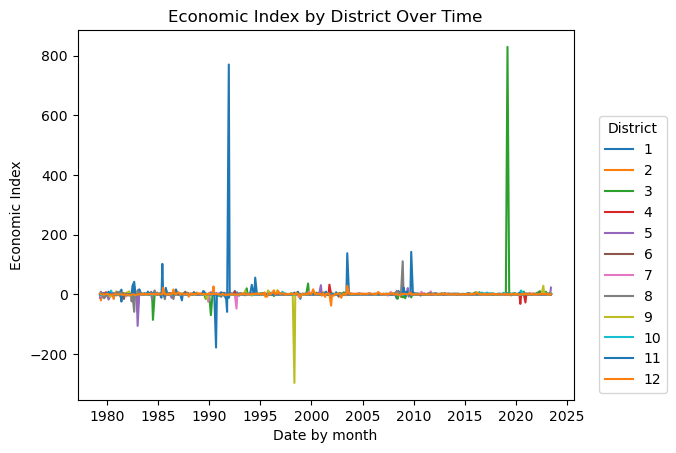

In [153]:
# Group the data by 'District'
grouped = bbLevels.groupby('District')

# Create a line plot for each group
for name, group in grouped:
    plt.plot(group['Date'], group['sentiment_growth_rate'], label=name)

# Add labels and a legend
plt.xlabel('Date by month')
plt.ylabel('Economic Index')
plt.title('Economic Index by District Over Time')
#plt.xticks(range(1, 45 + 1, 5), rotation=45)
plt.legend(title='District', loc='lower center', bbox_to_anchor=(1.12, 0), ncol=1)
# Show the plot
plt.show()


# Statistical Tables

In [155]:
bbSimple.columns

Index(['Date', 'USPHCI', 'District', 'econ_index', 'text', 'Year', 'City',
       'MonthName', 'MonthNumerical', 'compound_sentiment', 'mean_sentiment',
       'median_sentiment', '10th_decile_sentiment', '20th_decile_sentiment',
       '30th_decile_sentiment', '40th_decile_sentiment',
       '50th_decile_sentiment', '60th_decile_sentiment',
       '70th_decile_sentiment', '80th_decile_sentiment',
       '90th_decile_sentiment', '25th_quartile_sentiment',
       '50th_quartile_sentiment', '75th_quartile_sentiment', 'IQR_sentiment',
       'Blob_sentiment', 'financial_sentiment'],
      dtype='object')

In [156]:
bbSimple[['econ_index', 'compound_sentiment', 'mean_sentiment', 'IQR_sentiment']].describe()

,econ_index,compound_sentiment,mean_sentiment,IQR_sentiment
count,4242.000000,4242.000000,4242.000000,4242.000000
mean,1.989022,0.864181,0.127853,0.443621
std,5.834020,0.452598,0.081771,0.107984
min,-20.980000,-0.998400,-0.197844,0.000000
25%,-2.140000,0.987200,0.075606,0.381800
50%,0.600000,0.996200,0.132182,0.440400
75%,6.267500,0.998300,0.182429,0.509800
max,23.890000,0.999900,0.401186,0.994250


In [166]:
bbSimple[['econ_index', 'compound_sentiment', 'mean_sentiment', 'IQR_sentiment']].median()

econ_index            0.600000
compound_sentiment    0.996200
mean_sentiment        0.132182
IQR_sentiment         0.440400
dtype: float64

In [176]:
bbSimple[['econ_index', 'compound_sentiment', 'mean_sentiment', 'IQR_sentiment','Blob_sentiment','financial_sentiment']].corr()

,econ_index,compound_sentiment,mean_sentiment,IQR_sentiment,Blob_sentiment,financial_sentiment
econ_index,1.000000,0.063183,0.106018,0.021339,0.048084,0.094117
compound_sentiment,0.063183,1.000000,0.590132,-0.041783,0.186541,0.579842
mean_sentiment,0.106018,0.590132,1.000000,0.134564,0.350990,0.521098
IQR_sentiment,0.021339,-0.041783,0.134564,1.000000,0.173142,0.027760
Blob_sentiment,0.048084,0.186541,0.350990,0.173142,1.000000,0.278989
financial_sentiment,0.094117,0.579842,0.521098,0.027760,0.278989,1.000000


In [177]:
bbSimple.columns

Index(['Date', 'USPHCI', 'District', 'econ_index', 'text', 'Year', 'City',
       'MonthName', 'MonthNumerical', 'compound_sentiment', 'mean_sentiment',
       'median_sentiment', '10th_decile_sentiment', '20th_decile_sentiment',
       '30th_decile_sentiment', '40th_decile_sentiment',
       '50th_decile_sentiment', '60th_decile_sentiment',
       '70th_decile_sentiment', '80th_decile_sentiment',
       '90th_decile_sentiment', '25th_quartile_sentiment',
       '50th_quartile_sentiment', '75th_quartile_sentiment', 'IQR_sentiment',
       'Blob_sentiment', 'financial_sentiment'],
      dtype='object')

In [181]:
# Correlations of Sentiment measures
bbSimple[['econ_index','compound_sentiment', 'mean_sentiment', 'median_sentiment','IQR_sentiment','Blob_sentiment','financial_sentiment']].corr()

bbSimple[['econ_index', 'compound_sentiment','10th_decile_sentiment', '20th_decile_sentiment', '30th_decile_sentiment', '40th_decile_sentiment', '50th_decile_sentiment', '60th_decile_sentiment',
          '70th_decile_sentiment', '80th_decile_sentiment', '90th_decile_sentiment']].corr()

,econ_index,compound_sentiment,10th_decile_sentiment,20th_decile_sentiment,30th_decile_sentiment,40th_decile_sentiment,50th_decile_sentiment,60th_decile_sentiment,70th_decile_sentiment,80th_decile_sentiment,90th_decile_sentiment
econ_index,1.000000,0.063183,0.049256,0.071595,0.083315,0.041599,0.090787,0.103529,0.105931,0.104657,0.092587
compound_sentiment,0.063183,1.000000,0.407318,0.530971,0.686157,0.353502,0.239723,0.399063,0.557281,0.495189,0.420762
10th_decile_sentiment,0.049256,0.407318,1.000000,0.765094,0.534486,0.421514,0.448861,0.471520,0.410577,0.337510,0.258456
20th_decile_sentiment,0.071595,0.530971,0.765094,1.000000,0.714476,0.417384,0.452307,0.539830,0.506542,0.414621,0.323533
30th_decile_sentiment,0.083315,0.686157,0.534486,0.714476,1.000000,0.514437,0.358844,0.466488,0.526243,0.433847,0.327007
40th_decile_sentiment,0.041599,0.353502,0.421514,0.417384,0.514437,1.000000,0.640017,0.491082,0.493141,0.465441,0.382190
50th_decile_sentiment,0.090787,0.239723,0.448861,0.452307,0.358844,0.640017,1.000000,0.753323,0.627853,0.601891,0.512874
60th_decile_sentiment,0.103529,0.399063,0.471520,0.539830,0.466488,0.491082,0.753323,1.000000,0.824144,0.728934,0.626978
70th_decile_sentiment,0.105931,0.557281,0.410577,0.506542,0.526243,0.493141,0.627853,0.824144,1.000000,0.851375,0.715627
80th_decile_sentiment,0.104657,0.495189,0.337510,0.414621,0.433847,0.465441,0.601891,0.728934,0.851375,1.000000,0.827220


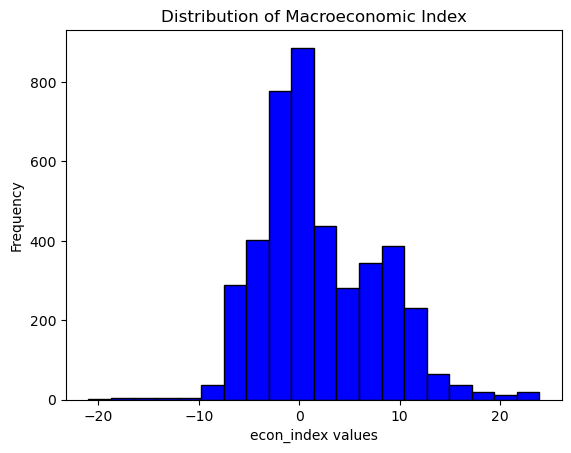

In [171]:
import matplotlib.pyplot as plt

# Assuming bbSimple is your DataFrame
# Replace 'econ_index' with your actual column name
econ_index_data = bbSimple['econ_index']

# Create a histogram
plt.hist(econ_index_data, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Macroeconomic Index')
plt.xlabel('econ_index values')
plt.ylabel('Frequency')

# Show the histogram
plt.show()


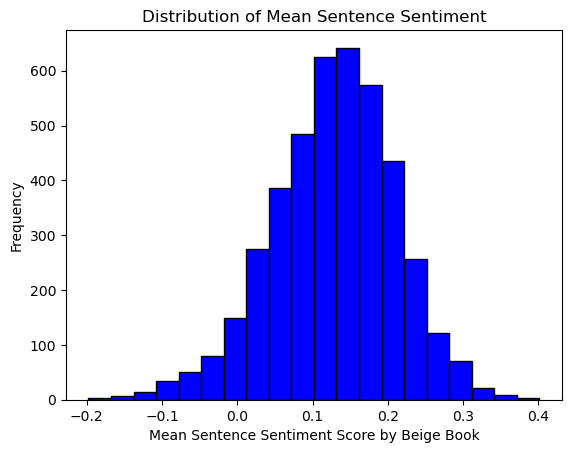

In [172]:
mean_sentiment = bbSimple['mean_sentiment']

# Create a histogram
plt.hist(mean_sentiment, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Mean Sentence Sentiment')
plt.xlabel('Mean Sentence Sentiment Score by Beige Book')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

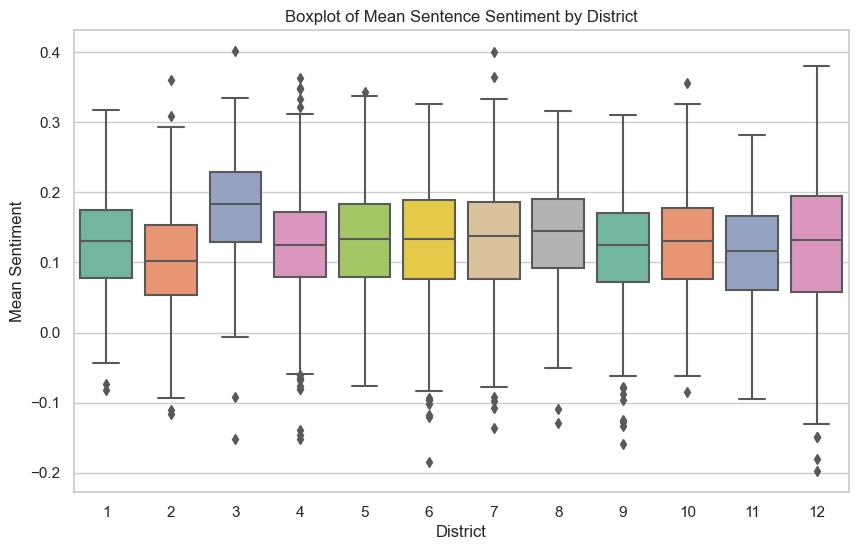

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming bbSimple is your DataFrame with a 'mean_sentiment' column and a 'District' column
# Replace 'mean_sentiment' and 'District' with the actual column names in your DataFrame
sns.set(style="whitegrid")  # Set the style of the plot

# Create a boxplot using seaborn
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.boxplot(x='District', y='mean_sentiment', data=bbSimple, palette='Set2')

plt.title('Boxplot of Mean Sentence Sentiment by District')
plt.xlabel('District')
plt.ylabel('Mean Sentiment')

plt.show()

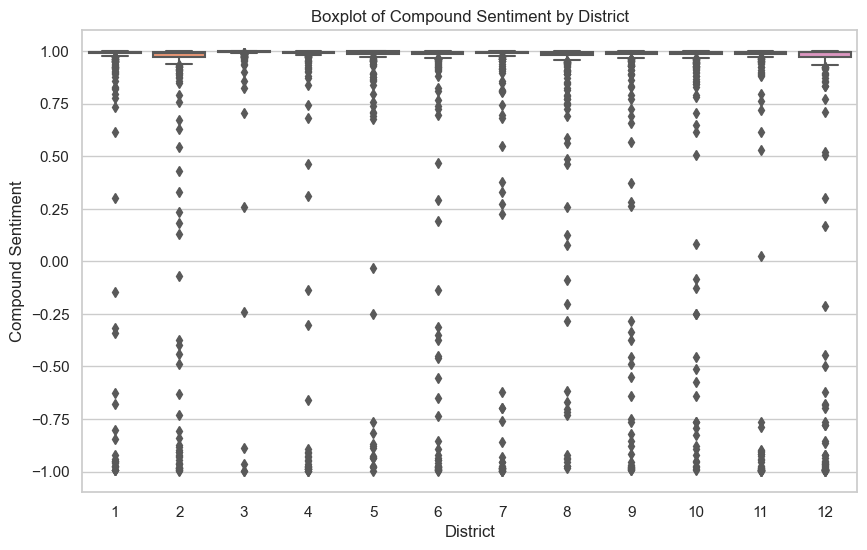

In [174]:
# Assuming bbSimple is your DataFrame with a 'mean_sentiment' column and a 'District' column
# Replace 'mean_sentiment' and 'District' with the actual column names in your DataFrame
sns.set(style="whitegrid")  # Set the style of the plot

# Create a boxplot using seaborn
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.boxplot(x='District', y='compound_sentiment', data=bbSimple, palette='Set2')

plt.title('Boxplot of Compound Sentiment by District')
plt.xlabel('District')
plt.ylabel('Compound Sentiment')

plt.show()